In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from Tools.config_helpers import loadConfig, make_small
from klepto.archives import dir_archive

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor, hist

from processor.trilep_analysis import trilep_analysis
from processor.default_accumulators import desired_output, add_processes_to_output, variations

In [3]:
# an equivalent code can be run with ipython -i trilep_analysis.py within the processor directory
from Tools.samples import fileset_2018, fileset_2018_small

overwrite = True
year      = 2018
small     = False

# load the config and the cache
cfg = loadConfig()

cacheName = 'trilep_analysis_SS_2tight'
if small: cacheName += '_small'

cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)

fileset = {
    'topW_v3': fileset_2018['topW_v3'],
    'topW_EFT_cp8': fileset_2018['topW_EFT_cp8'],
    'topW_EFT_mix': fileset_2018['topW_EFT_mix'],
    'TTW': fileset_2018['TTW'],
    'TTZ': fileset_2018['TTZ'],
    'TTH': fileset_2018['TTH'],
    'diboson': fileset_2018['diboson'],
    'ttbar': fileset_2018['top2l'],
    'DY': fileset_2018['DY'],
    'MuonEG': fileset_2018['MuonEG'],
    'DoubleMuon': fileset_2018['DoubleMuon'],
    'EGamma': fileset_2018['EGamma'],
}

fileset = make_small(fileset, small, n_max=1)  # run over just one file each if small is set to true

# add all processes to output so that the cutflow doesn't fail
add_processes_to_output(fileset, desired_output)

# add some histograms that we defined in the processor
# everything else is taken the default_accumulators.py
from processor.default_accumulators import mass_axis, dataset_axis
desired_output.update({
    "dilep_mass": hist.Hist("Counts", dataset_axis, mass_axis),
    "m3l": hist.Hist("Counts", dataset_axis, mass_axis),
})

histograms = sorted(list(desired_output.keys()))

exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
    "schema": NanoAODSchema,
}
exe = processor.futures_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")
    
    output = processor.run_uproot_job(
        fileset,
        "Events",
        trilep_analysis(year=year, variations=variations, accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )
    
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

I'm running now


Preprocessing:   0%|          | 0/1057 [00:00<?, ?file/s]

Processing:   0%|          | 0/1059 [00:00<?, ?chunk/s]

/home/users/hbronson/miniconda3/envs/coffeatest/lib/python3.8/site-packages/awkward/_connect/_numpy.py:150: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/home/users/hbronson/miniconda3/envs/coffeatest/lib/python3.8/site-packages/awkward/_connect/_numpy.py:150: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/home/users/hbronson/miniconda3/envs/coffeatest/lib/python3.8/site-packages/awkward/_connect/_numpy.py:150: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/home/users/hbronson/miniconda3/envs/coffeatest/lib/python3.8/site-packages/awkward/_connect/_numpy.py:150: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/home/users/hbronson/miniconda3/envs/coffeatest/lib/python3.8/site-packages/awkward/_connect/_numpy.py:150: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/home/users/hbronson/miniconda3/env

In [4]:
# we can just take the process list from the fileset to avoid any confusions
processes = list(fileset.keys())

processes.remove('topW_EFT_cp8')
processes.remove('topW_EFT_mix')

# the following list is directly taken from Tools/selection.py
lines = ['entry']
lines += [
            'filter',
            'lepveto',
            'trilep',
            'p_T(lep0)>25',
            'p_T(lep1)>20',
            'trigger',
            'offZ',
            'MET>50',
            'N_jet>2',
            'N_central>1',
            'N_btag>0',
            'N_fwd>0',
        ]

from Tools.helpers import getCutFlowTable
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, signal='topW_v3')
df

,topW_v3,TTW,TTZ,TTH,diboson,ttbar,DY,MuonEG,DoubleMuon,EGamma,S/B
entry,33.99 +/- 0.09,546.8 +/- 3.5,2267.0 +/- 4.0,612.5 +/- 1.4,34360.0 +/- 60.0,130300.0 +/- 100.0,385400.0 +/- 1200.0,543500.0 +/- 700.0,1016000.0 +/- 1000.0,300700.0 +/- 500.0,0.0000
filter,33.96 +/- 0.09,546.2 +/- 3.5,2264.0 +/- 4.0,611.9 +/- 1.4,34340.0 +/- 60.0,130200.0 +/- 100.0,385300.0 +/- 1200.0,543300.0 +/- 700.0,1016000.0 +/- 1000.0,300600.0 +/- 500.0,0.0000
lepveto,30.22 +/- 0.09,466.7 +/- 3.1,1919.0 +/- 3.0,493.3 +/- 1.3,33290.0 +/- 50.0,95340.0 +/- 120.0,335000.0 +/- 1200.0,376400.0 +/- 600.0,632000.0 +/- 800.0,255600.0 +/- 500.0,0.0000
trilep,11.91 +/- 0.06,148.3 +/- 1.2,736.2 +/- 2.1,135.0 +/- 0.7,12310.0 +/- 30.0,399.1 +/- 8.3,2436.0 +/- 100.0,7365.0 +/- 86.0,10780.0 +/- 100.0,7092.0 +/- 84.0,0.0003
p_T(lep0)>25,11.87 +/- 0.06,147.8 +/- 1.2,735.0 +/- 2.1,134.0 +/- 0.7,12190.0 +/- 30.0,393.7 +/- 8.1,2335.0 +/- 98.0,7283.0 +/- 85.0,10600.0 +/- 100.0,7083.0 +/- 84.0,0.0003
p_T(lep1)>20,11.62 +/- 0.05,144.8 +/- 1.2,725.9 +/- 2.1,129.4 +/- 0.6,11860.0 +/- 30.0,372.9 +/- 7.6,2152.0 +/- 94.0,7004.0 +/- 84.0,10140.0 +/- 100.0,6911.0 +/- 83.0,0.0003
trigger,11.35 +/- 0.05,141.2 +/- 1.1,715.9 +/- 2.1,126.2 +/- 0.6,11660.0 +/- 30.0,360.7 +/- 7.5,2069.0 +/- 92.0,4862.0 +/- 70.0,7585.0 +/- 87.0,2181.0 +/- 47.0,0.0004
offZ,10.11 +/- 0.05,125.7 +/- 1.1,150.4 +/- 0.9,108.5 +/- 0.6,2222.0 +/- 14.0,309.1 +/- 7.1,1328.0 +/- 73.0,1844.0 +/- 43.0,2194.0 +/- 47.0,705.0 +/- 26.6,0.0011
MET>50,8.295 +/- 0.046,101.0 +/- 1.0,104.4 +/- 0.8,85.98 +/- 0.53,1109.0 +/- 10.0,213.7 +/- 5.6,158.1 +/- 24.1,837.0 +/- 28.9,941.0 +/- 30.7,278.0 +/- 16.7,0.0022
N_jet>2,7.557 +/- 0.044,69.15 +/- 0.83,88.46 +/- 0.72,71.98 +/- 0.48,237.3 +/- 4.8,103.1 +/- 3.8,31.46 +/- 10.67,315.0 +/- 17.7,297.0 +/- 17.2,99.0 +/- 9.95,0.0058


In [5]:
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, absolute=False, signal='topW_v3')
df

,topW_v3,TTW,TTZ,TTH,diboson,ttbar,DY,MuonEG,DoubleMuon,EGamma
entry,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
filter,0.9991,0.9991,0.9990,0.9989,0.9996,0.9997,0.9998,0.9996,0.9997,0.9995
lepveto,0.8898,0.8543,0.8476,0.8062,0.9694,0.7321,0.8694,0.6928,0.6222,0.8504
trilep,0.3941,0.3177,0.3836,0.2736,0.3699,0.0042,0.0073,0.0196,0.0171,0.0277
p_T(lep0)>25,0.9965,0.9968,0.9983,0.9930,0.9896,0.9865,0.9587,0.9889,0.9828,0.9987
p_T(lep1)>20,0.9790,0.9797,0.9876,0.9655,0.9736,0.9472,0.9218,0.9617,0.9570,0.9757
trigger,0.9769,0.9753,0.9862,0.9755,0.9828,0.9673,0.9613,0.6942,0.7477,0.3156
offZ,0.8910,0.8902,0.2100,0.8595,0.1905,0.8571,0.6420,0.3793,0.2893,0.3232
MET>50,0.8203,0.8033,0.6943,0.7925,0.4993,0.6914,0.1190,0.4539,0.4289,0.3943
N_jet>2,0.9110,0.6848,0.8473,0.8372,0.2139,0.4824,0.1991,0.3763,0.3156,0.3561


In [6]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from plots.helpers import makePlot

# defining some new axes for rebinning.
N_bins = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
mass_bins = hist.Bin('mass', r'$M\ (GeV)$', 20, 0, 600)
m3l_bins = hist.Bin('mass', r'$M\ (GeV)$', [0,110,150,200,400])
pt_bins = hist.Bin('pt', r'$p_{T}\ (GeV)$', 30, 0, 300)
pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', 10, 0, 300)
eta_bins = hist.Bin('eta', r'$\eta $', 25, -5.0, 5.0)

my_labels = {
    'topW_v3': 'top-W scat.',
    'topW_EFT_cp8': 'EFT, cp8',
    'topW_EFT_mix': 'EFT mix',
    'TTZ': r'$t\bar{t}Z$',
    'TTW': r'$t\bar{t}W$',
    'TTH': r'$t\bar{t}H$',
    'diboson': 'VV/VVV',
    'ttbar': r'$t\bar{t}$',
    'DY': 'Drell-Yan',
}

my_colors = {
    'topW_v3': '#FF595E',
    'topW_EFT_cp8': '#000000',
    'topW_EFT_mix': '#0F7173',
    'TTZ': '#FFCA3A',
    'TTW': '#8AC926',
    'TTH': '#34623F',
    'diboson': '#525B76',
    'ttbar': '#1982C4',
    'DY': '#6A4C93',}

Here are the graphs:

In [ ]:
makePlot(output, 'fwd_jet', 'pt',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (fwd jet) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'DY','ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

In [ ]:
makePlot(output, 'N_mu', 'multiplicity',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{mu}$',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'DY','ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

In [ ]:
makePlot(output, 'N_ele', 'multiplicity',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{ele}$',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'DY','ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

In [ ]:
makePlot(output, 'MET', 'pt',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}^{miss}$ (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ','DY', 'ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

In [ ]:
makePlot(output, 'lead_lep', 'pt',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

In [ ]:
makePlot(output, 'N_jet', 'multiplicity',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=N_bins, log=True, normalize=False, axis_label=r'$N_{jet}$',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'DY','ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

In [ ]:
makePlot(output, 'N_b', 'multiplicity',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{b}$',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'DY','ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

In [ ]:
makePlot(output, 'N_fwd', 'multiplicity',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{fwd}$',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'DY','ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

In [ ]:
makePlot(output, 'dilep_mass', 'mass',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=mass_bins, log=True, normalize=False, axis_label=r'$M_{\ell\ell}$ (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'DY','ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

In [ ]:
makePlot(output, 'trail_lep', 'pt',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (trail lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 155.0 MC: 133.39


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


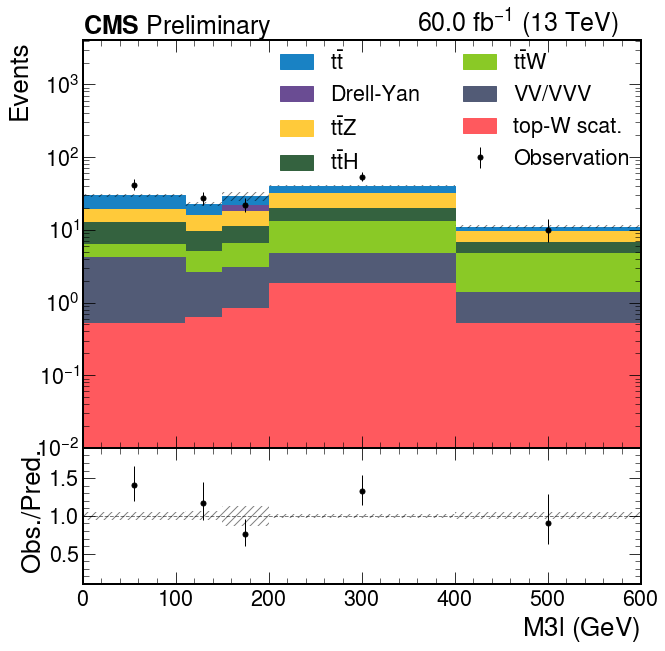

In [7]:
makePlot(output, 'm3l', 'mass',
         data=['MuonEG', 'DoubleMuon', 'EGamma'],
         bins=m3l_bins, log=True, normalize=False, axis_label=r'$M3l$ (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'DY','ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )